<a href="https://colab.research.google.com/github/huskeypm/cellmigration/blob/main/expt_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exptl analysis
Last ran on colab, 240711

This notebook
* loads tif files from a migration experiment,
* uses trackpy to find moving cells, and
* fits a linear equation to their mean square displacements to obtain a diffusion coefficient.

Data
* My input data is currently located at
/content/drive/MyDrive/public/
which is mounted to google drive.
* This path will need to be adjusted if data are stored elsewhere

Usage:
* Copy files of interest to an appropriate google drive directory
(current set is from Emily's Feb collections)
* run the first part of the code to completion and **modify the default parameters** to work with your data
* once the right parameters are determined, process your remaining files; a csv file should result for each input file

To analyze
* Use second part of notebook to load in csv files and plot

# Install needed packages



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip3 install pims trackpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pims: filename=PIMS-0.7-py3-none-any.whl size=84590 sha256=f8184225455c719f45086645226eb75f9c99aa78c932dc7990472c4d16778ed6
  Stored in directory: /root/.cache/pip/wheels/54/cb/f1/939f4adc0c5bcb1a1a78566d67869368d3d8dc8abd84f63c38
  Created wheel for trackpy: filename=trackpy-0.6.4-py3-none-any.whl size=130037 sha256=b2f744ea3a716d22ac26bdbd3cd4a297922f129338a3ae67bbd60db5177cf3c9
  Stored in directory: /root/.cache/pip/wheels/8c/05/a3/661d7351b14ce3a71a99bdb89b0daa5ad07f293e7a4fbb5857
Successfully built pims trackpy


Check out cellmigration github repo

In [3]:
!git clone https://github.com/huskeypm/cellmigration.git
#!cd cellmigration; git pull

Cloning into 'cellmigration'...
remote: Enumerating objects: 920, done.
remote: Counting objects: 100% (236/236), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 920 (delta 165), reused 150 (delta 120), pack-reused 684
Receiving objects: 100% (920/920), 15.74 MiB | 13.02 MiB/s, done.
Resolving deltas: 100% (572/572), done.


In [4]:
import sys
sys.path.append("cellmigration")

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import pims
import trackpy as tp
import tifffile

import expt_analysis.trackcells as tc

# Process raw images
## Image processing

Define inputs (pretty much the only places needed for making changes)

In [6]:
!ls /content/cellmigration

batchProcess.py    concentration.py	      LICENSE		     README_1.md
brownian_v2.py	   conda_openmm_pytraj.ipynb  master.ipynb	     README.md
brownian_v3.py	   config.bash		      migration_paper.ipynb  run
brownian_v4.py	   cont_analysis	      paper		     states.py
brownian_v5.py	   expt_analysis	      parameters.py	     TAM_example.ipynb
brown_util.py	   expt_analysis.ipynb	      pdb_antiquated.py      tests
brown_wnonbond.py  histo.ipynb		      processData.py	     update.py
calculator.py	   lattice.py		      processYaml.py	     validation.py


In [16]:
# read in image and show first frame
user = "local"
user = "remote"
useGdrive = False
if user == "local":
  name='1'
  path="/home/ekrueger2/microscopy_data/050124"
  fileName=path+"/Position{}_050124.tif".format(name)
    #fileName=r"C:\Users\ekrue\Downloads\12_13_23_{}.tif".format(name)
elif user == "remote":
  name = "1" #
  name = "3"
  gpath=('/content/drive')
  path=gpath+"/MyDrive/public/"
  fileName = path+"/Position_%s_movie.tif"%name
  useGdrive=True
  sourcePath = "/content/cellmigration/"
#
#  Parameters to edit
#
# time/frame conversion
fr = 180 # s/fr # experiment

# image processing parameters (disable downsample and crop for full analyses )
downsampleRate = 10
#crop=[[300,900],[300,900]]
crop=[[300,600],[500,800]]

thresh=105


# determine parameters to track particles
# paramters: diameter, minmass
#- positiion 1
#iameter=101 # adjust me first
#inmass = 75000
#- positiion 2
#diameter=91  # adjust me first
#minmass = 100
#- positiion 3
#diameter=101  # adjust me first
#minmass = 1000
#cropped position 1 values
diameter=21
minmass=15000

# for fitting MSDs
fittingRange=[0,100]



## Read images


### Mount google drive.
I added a shortcut to a shared tif file in my 'public' directory

 /content/drive/MyDrive/public/

In [10]:
if useGdrive:
  from google.colab import drive
  drive.mount(gpath)

Mounted at /content/drive


(480, 1200, 1200)


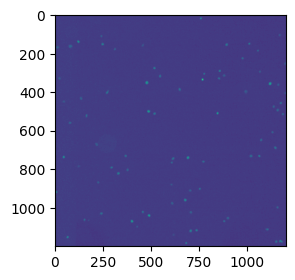

In [17]:
# read image
raw_data = tifffile.imread(fileName)
print(raw_data.shape)

multiChannel = False
if multiChannel:
  channel=0
  frames=raw_data[:,channel,:,:]
else:
  frames=raw_data[:,:,:]

plt.imshow(frames[0,:,:])


### Apply threshold to suppress background noise

(48, 300, 300)


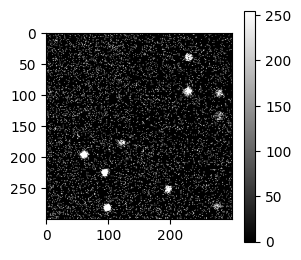

In [18]:

thresh=105
threshed = tc.ProcessFrames(frames,
                            downsampleRate=downsampleRate,
                            crop=crop,thresh=thresh)



#print(np.min(threshed[0,:]))


### Tracking

* If cells aren't detecting, reduce diameter/minmass or both.
* The displayed mass histogram can help with this optimization

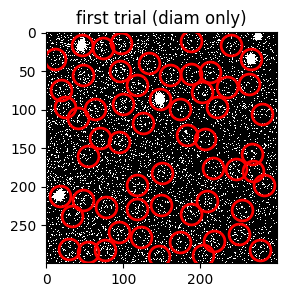

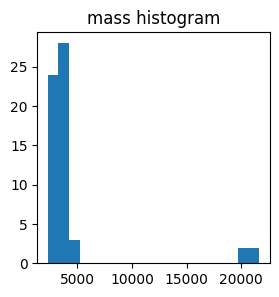

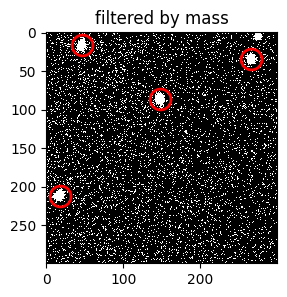

In [19]:

dummy = tc.TrialParams(threshed,refFrame=0,diameter=diameter,minmass=minmass)
if dummy.shape[0] <1:
  print("Error finding cells; try different parameters")
else:
  finalStack = threshed


In [20]:
# run batch/tracking
fb=tc.DoTracking(finalStack,diameter=diameter,minmass=minmass)

try:
  print("shape final %d"%fb.shape[0])
except:
  print("Unsuccessful tracking")

fb

Frame 47: 4 features
shape final 178


,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,16.569210,45.859648,20041.016267,5.366195,0.210051,144.397483,50490.0,NaN,0
1,34.419757,266.075299,20880.950270,5.098328,0.047225,148.220009,47685.0,NaN,0
2,86.227289,147.267142,20583.330093,5.306335,0.166261,143.944717,50745.0,NaN,0
3,211.868207,17.009377,21647.726808,5.375536,0.122037,138.956877,51765.0,NaN,0
4,25.925325,261.147956,20663.524663,4.860744,0.049706,158.305665,42840.0,NaN,1
...,...,...,...,...,...,...,...,...,...
173,285.649493,97.259769,16953.751050,4.326272,0.029343,170.711945,36210.0,NaN,46
174,93.500002,227.329294,17200.988362,4.668128,0.061116,166.344827,37995.0,NaN,47
175,195.659209,60.733602,17320.426621,4.349032,0.057750,171.285366,37485.0,NaN,47
176,224.539656,94.087434,16866.468139,4.221903,0.074306,176.996973,33405.0,NaN,47


### MSD analyses
- Based on the cell trajectories identified above

<font color=red>WARNING: the msd plot needs to be rescaled according to correct spatial and temporal units</font>

Frame 47: 4 trajectories present.
Found 178 
Retained 131 particles
Drift 
                y           x
frame                       
1     -28.602033   -9.326013
2     -48.054539   -2.770536
3     -23.627671   -1.082172
4     -18.628260    0.693555
5      -5.785268  -27.701682
6      -4.003041  -28.744854
7      -7.112059  -43.030982
8      -0.355156  -59.586591
9       8.445251  -60.999260
10      7.722236  -78.414409
11     18.247989  -92.967364
12     38.163004 -112.153988
13     45.533225 -115.538883
14     54.570892 -124.290548
15     58.534181 -126.395192
16     64.261054 -132.827808
17     63.440267 -131.496172
18     62.930589 -131.419526
19     62.494391 -131.886840
20     63.759406 -132.408854
21     57.651664 -139.233057
22     73.830773 -160.005613
23     87.057801 -180.738350
24     63.993522 -179.056182
25     56.251452 -174.890405
26     55.389508 -162.301155
27     45.706629 -160.720435
28     53.254270 -160.240899
29     58.552700 -145.538732
30     65.477670 -142.523

<Figure size 500x300 with 0 Axes>

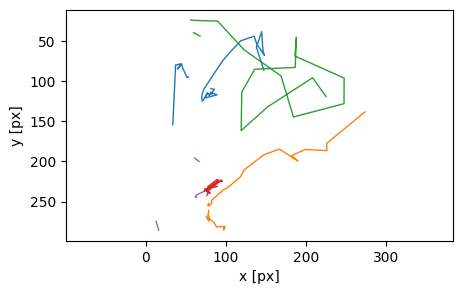

Double check, data contains ALL particle trajectories? (%d)


<Figure size 500x300 with 0 Axes>

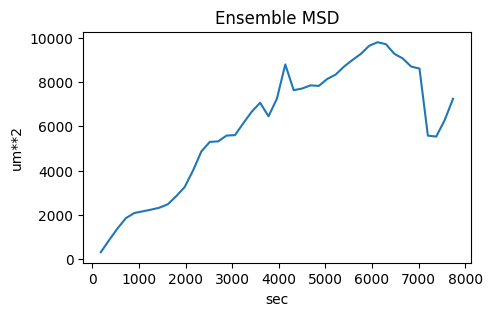

In [21]:
# compute MSD
ts,traj,msd,im,em=tc.DoMSD(
    fb,
    maxDist=80, # maximum displacement between frames in pixel
    maxMissFrame=10, # allowed number of frames a particle can disappear
    minFrame=10, # minimum number of frames a trajectory needs to last
    pixelSize=1.1, # image pixel size in micron/pixel, specific for each scope and lens (Cytiva 10X: 0.65) and (Spinning Disk: 1.1 at 10X)
    frameRate=1/fr, # image acquisition rate in frames/sec
    max_lagtime=160, # intervals of frames out to which MSD is computed
    name=name
)


### Optional plot
- shows how tracked cells moved

!!!! Need to debug slightly, since incorrect image is being loaded

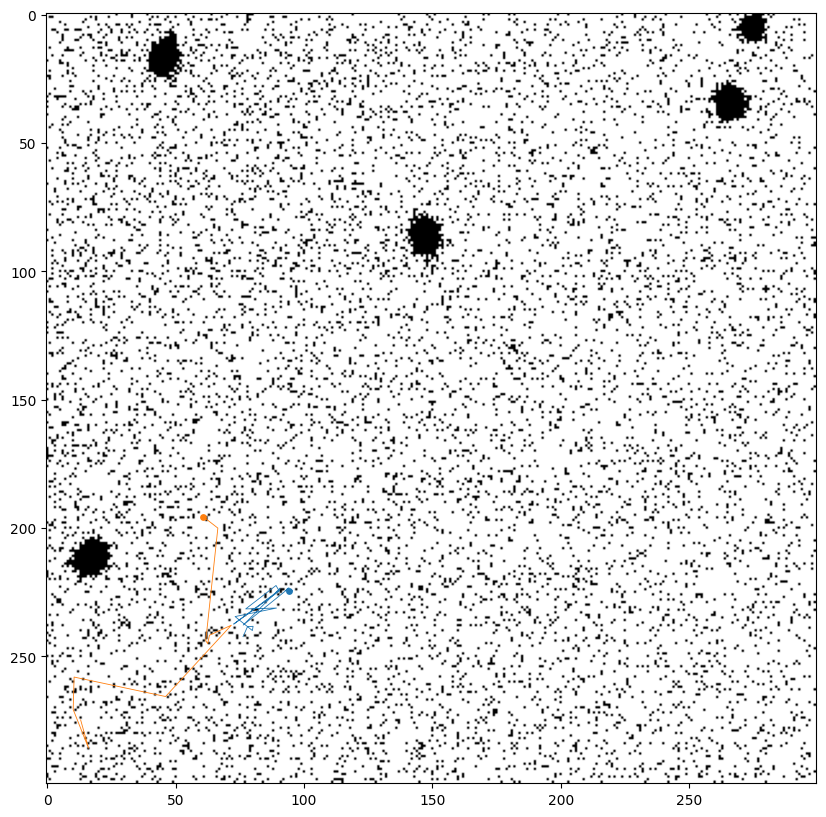

In [22]:
showTraj=True
if showTraj:
  fig=plt.figure(figsize=(10,10))
  ax=fig.add_subplot(111)
  ax.imshow(threshed[0,:,:],cmap='Greys')

  for j in traj['particle'].unique():
      xs=traj[traj['particle']==j]['x'].tolist()
      ys=traj[traj['particle']==j]['y'].tolist()

      # remove ones at the edge
      if xs[-1]-xs[0]<10:
          continue

      nFrames=len(xs)
      cs=np.linspace(0,1,nFrames)
      ax.plot(xs,ys,lw=0.6)
      plt.scatter(xs[-1],ys[-1],s=15)

slope/intercept [1.03855527e+00 1.90120624e+03]


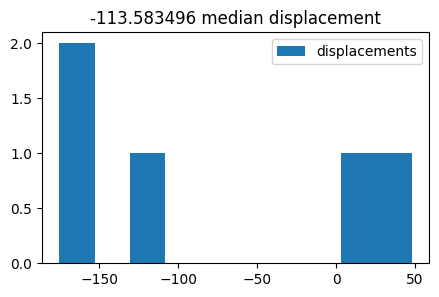

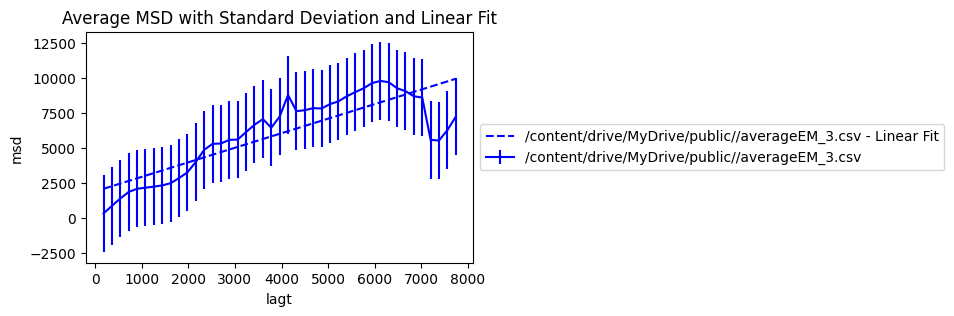

In [23]:



# get displacements
dists, xdists = tc.CalcDistances(traj) # performed on trajectories BEFORE drift-correction
med = np.median(xdists)
plt.figure()
plt.title("%f median displacement"%med)
plt.hist(xdists,label="displacements")
plt.legend(loc=0)

# save average MSD for each run to csv file
msdFileName=path+'/averageEM_{}.csv'.format(name)
diffFileName=path+'/diff_{}.csv'.format(name)
if name is not None:
    em.to_csv(msdFileName)
    np.savetxt(diffFileName,np.array(xdists))
    # prompt: save pandas dataframe
    traj.to_csv(path+'/traj_{}.csv'.format(name))
    fb.to_csv(path+'/fbframe_{}.csv'.format(name))

msdFile={
    path+'/averageEM_{}.csv'.format(name):{"color":"blue"}
}
plt.figure()
tc.doMSDFit(msdFile, fittingRange=fittingRange)

#individual MSDs? save figures?

### Count left moving/right moving cells
- I believe Xuan implemented this, but I haven't validated it myself

In [26]:
segInterval=15
nSeg=int(frames.shape[0]/segInterval)

trajs=[]
for seg in range(nSeg):
    ar_tmp=threshed[seg*segInterval:(seg+1)*segInterval,:,:].copy()
    minFrame=segInterval
    f = tp.batch(ar_tmp, diameter, minmass=minmass)
    t_before = tp.link(f, 20, memory=10)
    traj = tp.filter_stubs(t_before, segInterval)
    trajs.append(traj)

Frame 2: 4 features


Process ForkPoolWorker-9:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/usr/lib/python3.10/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt


KeyboardInterrupt: 

IndexError: list index out of range

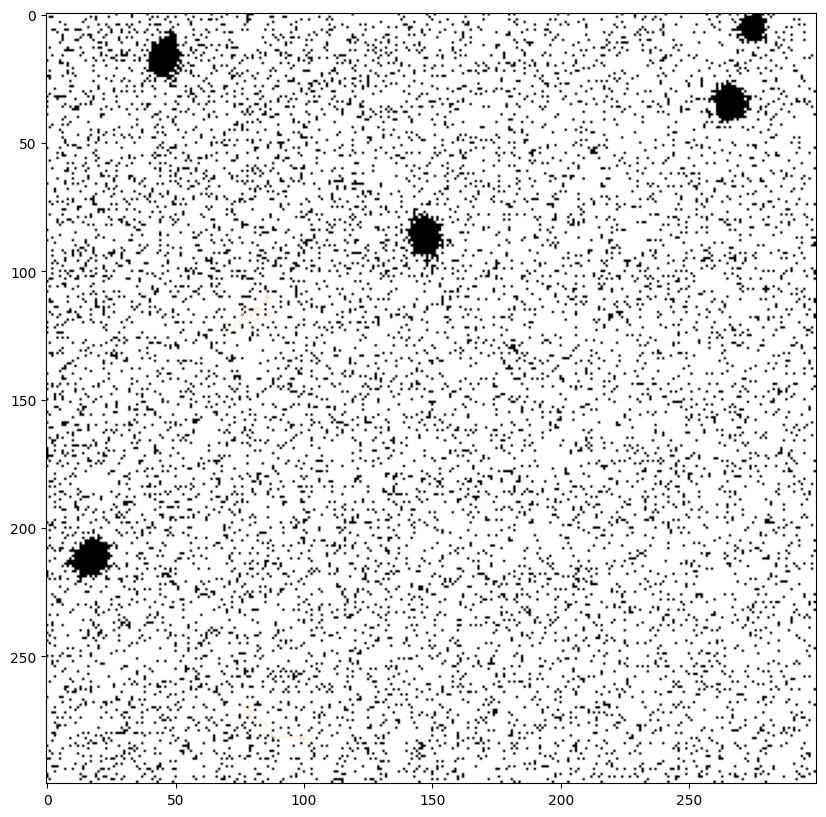

In [27]:
import matplotlib
cmap1=matplotlib.colormaps['GnBu'] # left-shifting
cmap2=matplotlib.colormaps['OrRd'] # right-shifting
gradient=np.linspace(0.1,1,nSeg)
counts1=0
counts2=0

fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
ax.imshow(threshed[0,:,:],cmap='Greys')

for seg in range(nSeg):
    traj=trajs[seg]

    for j in traj['particle'].unique():
        xs=traj[traj['particle']==j]['x'].tolist()
        ys=traj[traj['particle']==j]['y'].tolist()

        if np.abs(xs[-1]-xs[0])<2:
            continue

        nFrames=len(xs)
        cs=np.linspace(0,1,nFrames)

        if xs[-1]<xs[0]:
            cmap=cmap1
            if seg < nSeg/3:
                counts1+=1
        else:
            cmap=cmap2
            if seg < nSeg/3:
                counts2+=1

        plt.plot(xs,ys,c=cmap(gradient[seg]),lw=0.6)
        plt.scatter(xs[-1],ys[-1],color=cmap(gradient[seg]),s=10)

print('Left-shifting:', counts1, ' Right-shifting:', counts2)

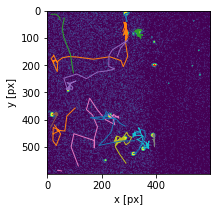

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [ ]:
plt.figure()
plt.imshow(threshed[0,:,:])
tp.plot_traj(traj)

# Post processing
- This should be treated as skeleton code, as the processing of results still needs to be retooled



Create list of names

In [ ]:
path

'/home/ekrueger2/microscopy_data/022824'

slope/intercept [  2.13669037 638.39398653]


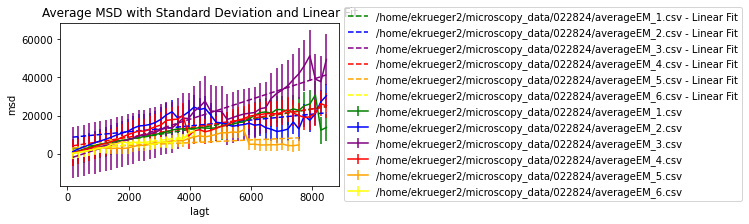

In [ ]:
# import average MSD csv files and plot with Std and linear fit

average_MSD_files={
    'averageEM_Position1.csv':{"color": "blue"},
    'averageEM_Position2.csv':{"color": "purple"},
    'averageEM_Position3.csv':{"color": "red"},
    'averageEM_Position4.csv':{"color": "orange"},
    'averageEM_Position5.csv':{"color": "yellow"},
    'averageEM_Position6.csv':{"color": "green"}
    }
average_MSD_files={
    path+'/averageEM_1.csv':{"color": "green"},
    path+'/averageEM_2.csv':{"color": "blue"},
    path+'/averageEM_3.csv':{"color": "purple"},
    path+'/averageEM_4.csv':{"color": "red"},
    path+'/averageEM_5.csv':{"color": "orange"},
    path+'/averageEM_6.csv':{"color": "yellow"},
}


fittingRange=[0,100]
tc.doMSDFit(average_MSD_files, fittingRange=fittingRange)



<font color=red>NEED TO EDIT ONCE I HAVE THE low/high ATP JOBS </font>


### No ATP

Not sure how this naming scheme was decided upon

In [ ]:
# former path
filenames_confinement = []
filenames_confinement.append(
    path+'/averageEM_Position_1.csv'
    )
diff_filenames = []
diff_filenames.append(
    path+'/diff_Position_1.csv'
    )
caseNames = ["-ATP" for x in range(len(filenames_confinement))]


### With ATP

In [ ]:
# with atp?
filenames_confinement_ATP = []
filenames_confinement_ATP.append(
    path+'/averageEM_Position_2.csv'
    )
diff_filenames_ATP = []
diff_filenames_ATP.append(
    path+'/diff_Position_2.csv'
    )

caseNamesATP = ["+ATP" for x in range(len(filenames_confinement_ATP))]
#print(casesATP)

In [ ]:
filenames_confinement =  filenames_confinement + filenames_confinement_ATP
diff_filenames =  diff_filenames + diff_filenames_ATP
caseNames = caseNames + caseNamesATP

In [ ]:
print(filenames_confinement)

['/content/drive/MyDrive/public//averageEM_Position_1.csv', '/content/drive/MyDrive/public//averageEM_Position_2.csv']


### Load data
We used to load/process images here, but now we just use postprocessed data here (tracking happens elsewhere in notebook)

In [ ]:
cases = dict()
class empty:pass

In [ ]:
for i,filename in enumerate(filenames_confinement):

    # store data
    case = empty()

    #
    case.name = filenames_confinement[i]
    ar = pd.read_csv(filenames_confinement[i])
    print("Lag time isn't quite what we want")
    case.time1 = ar['lagt']
    case.dataavg1 = ar['msd']
    print("D is needed")
    ar = pd.read_csv(filename)
#    case.D = D
    ar = pd.read_csv(diff_filenames[i])
    case.dists = ar

    cases[caseNames[i]] = case


Lag time isn't quite what we want
D is needed
Lag time isn't quite what we want
D is needed


Text(0, 0.5, 'Prob')

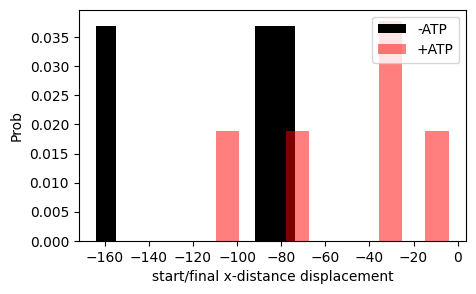

In [ ]:
caseName='-ATP'
case = cases[caseName]
plt.hist(case.dists,density=True,color='black',label='-ATP')

caseName='+ATP'
case = cases[caseName]
plt.hist(case.dists,alpha=0.5,density=True,color='red',label='+ATP')
plt.legend(loc=0)
plt.xlabel("start/final x-distance displacement")
plt.ylabel("Prob")


* Tests
```
cd tests
```
* Run (kafka)
```
python3 ../brownian_v3.py -yamlFile expt.yaml -run
```
* Process
```
python3 batchProcess.py -single expt # kant for now
```
* upload expt.csv



In [ ]:
sourcePath = "/content/cellmigration/"
simFile = sourcePath+"expt_analysis/expt.csv"
simData = np.loadtxt(simFile)

batchProcess.py    concentration.py	      LICENSE		     README_1.md
brownian_v2.py	   conda_openmm_pytraj.ipynb  master.ipynb	     README.md
brownian_v3.py	   config.bash		      migration_paper.ipynb  run
brownian_v4.py	   cont_analysis	      paper		     states.py
brownian_v5.py	   expt_analysis	      parameters.py	     TAM_example.ipynb
brown_util.py	   expt_analysis.ipynb	      pdb.py		     tests
brown_wnonbond.py  histo.ipynb		      processData.py	     update.py
calculator.py	   lattice.py		      processYaml.py	     validation.py


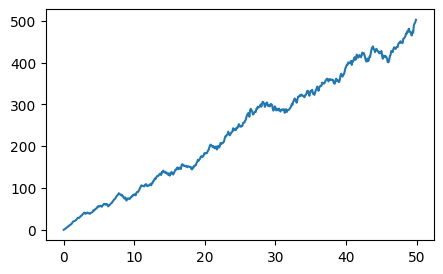

In [ ]:
plt.plot(simData[:,0],simData[:,1])

<font color=red>Need to also load sim case where we measure displacements </font>

Not storing D right now until timescale is worked out


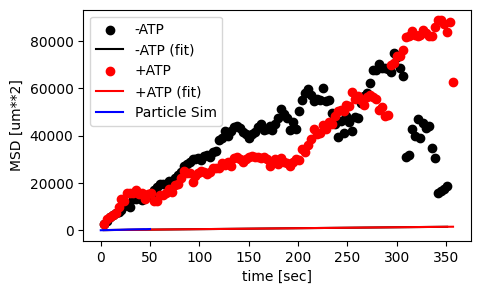

In [ ]:
print("Not storing D right now until timescale is worked out")
sec_to_min = 60.
caseName = '-ATP'
case = cases[caseName]
t = case.time1/sec_to_min
plt.scatter(t,case.dataavg1,facecolor='k',label=caseName)
case.D = 1
msd = np.array(t)*4*case.D + 50
plt.plot(t, msd,'k',label=caseName+" (fit)")

caseName = '+ATP'
case = cases[caseName]
t = case.time1/sec_to_min
plt.scatter(t,case.dataavg1,facecolor='r',label=caseName)
case.D = 1
msd = np.array(t)*4*case.D + 50
plt.plot(t, msd,color='r',label=caseName+" (fit)")

# sims
plt.plot(simData[:,0],simData[:,1],color='b',label="Particle Sim")


plt.xlabel("time [min]")
plt.ylabel("MSD [um**2]")
plt.legend(loc=0)
plt.gcf().savefig("msd.png",dpi=300)

In [ ]:
msd[9]

206.09947014256585